Época 1, Erro: 2.731068271953369
Época 2, Erro: 2.6811986956086633
Época 3, Erro: 2.6185378103408192
Época 4, Erro: 2.5531744334723436
Época 5, Erro: 2.48784891608483
Época 6, Erro: 2.42340488091601
Época 7, Erro: 2.360178670585509
Época 8, Erro: 2.2983568632567715
Época 9, Erro: 2.238069046318783
Época 10, Erro: 2.1794128261298313
Época 11, Erro: 2.1224616382038723
Época 12, Erro: 2.0672682562001663
Época 13, Erro: 2.013867236722934
Época 14, Erro: 1.962277075945033
Época 15, Erro: 1.9125022382837398
Época 16, Erro: 1.8645350715825473
Época 17, Erro: 1.8183575953625988
Época 18, Erro: 1.7739431489083337
Época 19, Erro: 1.731257891626085
Época 20, Erro: 1.6902621537546303
Época 21, Erro: 1.6509116399969221
Época 22, Erro: 1.6131584918948418
Época 23, Erro: 1.5769522169932237
Época 24, Erro: 1.5422404942324237
Época 25, Erro: 1.5089698657615938
Época 26, Erro: 1.477086325638527
Época 27, Erro: 1.4465358157978407
Época 28, Erro: 1.4172646393374397
Época 29, Erro: 1.3892198006575336
Época

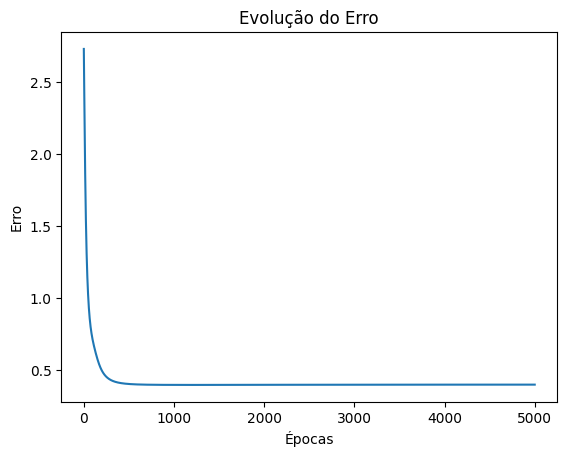

Entrada: [-1 -1], Saída esperada: [0], Previsão: [np.float64(0.3040566880132669)]
Entrada: [-1  1], Saída esperada: [1], Previsão: [np.float64(0.8597447990314233)]
Entrada: [ 1 -1], Saída esperada: [1], Previsão: [np.float64(0.3690361823532882)]
Entrada: [1 1], Saída esperada: [0], Previsão: [np.float64(0.35298035603067496)]


In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt


# calculo diferencial entre dois pontos 
    

def diferencial(f,x, h=1e-5):
        return (f(x + h) - f(x)) / h


class Neuronio:

    def __init__(self,d,phi):       
        #super.__init__()
        self.d = d
        self.phi = phi 

        self.w = np.random.uniform(-1, 1, d)

        self.b = np.random.uniform(-1, 1)
        
        self.delta_w = np.zeros(d)

        self.delta_b = 0

        self.h = 0 
        self.y = 0
        self.y1 = 0
    
    
    def propagar(self,x):
        self.h = np.dot(self.w, x) + self.b # np.dot representa o escalar 
        self.y = self.phi(self.h)
        self.y1 = diferencial(self.phi,self.h)
        return self.y 
       
    

    def adaptar(self, delta, y_anterior, alpha, beta): 
        y_anterior = np.array(y_anterior)
        Mw = beta * self.delta_w
        self.deltaw = -alpha * self.y1 * delta * y_anterior + beta + Mw
        self.w += self.delta_w

        Mb = beta * self.delta_b
        self.delta_b = -alpha * self.y1 * delta + Mb
        self.b += self.delta_b

        


class CamadaDensa:
    def __init__(self, de, ds, phi):
        self.de = de 
        self.ds = ds
        self.phi = phi 

        self.neuronios = [Neuronio(de, phi) for _ in range(ds)]

    def propagar(self, x):
        self.y = [neuronio.propagar(x) for neuronio in self.neuronios]
        return self.y 
    
    def saida(self):
        return [neuronio.y for neuronio in self.neuronios]
     
    def adaptar(self, delta_n, y_anterior, alpha, beta):
        for j in range(self.ds):
            self.neuronios[j].adaptar(delta_n[j], y_anterior, alpha, beta)
    
class CamadaEntrada:
    def __init__(self, ds):
        self.ds = ds  
        self.y = [0 for _ in range(ds)]

    def propagar(self, x):
        self.y = x  
        return self.y

class RedeNeuronal:
    def __init__(self, forma, phi):
        self.camadas = []   
        self.N = len(forma)  
        ds1 = forma[0]
        camada_entrada = CamadaEntrada(ds1)
        self.camadas.append(camada_entrada)

        for n in range(1, self.N):
            de_n = forma[n - 1]  
            ds_n = forma[n]  
            camada_densa = CamadaDensa(de_n, ds_n, phi)
            self.camadas.append(camada_densa)

    def delta_saida(self, yN, y):
        return [yN[k] - y[k] for k in range(len(y))]
    
    def retropropagar(self, deltaN, alpha, beta):
        delta_atual = deltaN
        
        for n in range(len(self.camadas) -1, 0, -1): 
            camada_atual = self.camadas[n]
            camada_anterior = self.camadas[n - 1]


            y_anterior = camada_anterior.y
            #derivada_anterior = [neuronio.y1 for neuronio in camada_anterior.neuronios]
            if isinstance(camada_anterior, CamadaDensa):
                derivada_anterior = [neuronio.y1 for neuronio in camada_anterior.neuronios]
            else:
                derivada_anterior = [1] * len(camada_anterior.y)  # Derivada trivial para a entrada

            delta_anterior = []
            for i in range(len(camada_anterior.y)):
                soma = sum(
                    camada_atual.neuronios[J].w[i] * delta_atual[J]
                    for J in range(len(camada_atual.neuronios))
                )
                delta_anterior.append(soma * derivada_anterior[i])

            camada_atual.adaptar(delta_atual, y_anterior, alpha, beta)
            delta_atual = delta_anterior
    
    def adaptar(self, x, y, alpha, beta):
        yN = self.propagar(x)
        delta_n = self.delta_saida(yN, y)

        self.retropropagar(delta_n, alpha, beta)

        k = len(delta_n)
        erro_medio = (1/k) * sum(delta ** 2 for delta in delta_n)

        return erro_medio

    def treinar(self, x, y, n_epocas, epsilon_max, alpha, beta):
        historico_erro = []

        for epoca in range(n_epocas):
            erro_epoca = 0

            for entrada,saida in zip(x,y):
                erro_x = self.adaptar(entrada,saida, alpha, beta)
                erro_epoca = max(erro_epoca, erro_x)

            historico_erro.append(erro_epoca)
            print(f"Época {epoca + 1}, Erro: {erro_epoca}")

            if erro_epoca <= epsilon_max:
                print("Treinamento concluído. Erro aceitável atingido.")
            #break

        return historico_erro
    
    def prever(self,X):
        Y = [self.propagar(x) for x in X]
        return Y

    def propagar(self, x):
        y = x
        for camada in self.camadas:
            y = camada.propagar(y)
        return y
    
    
    
   
    
# ambiente de testes para o problema XOR 

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) # np.exp significa o exponencial do valor

def sigmoid_derivada(x):
    s = sigmoid(x)
    return s * (1-s)

def tah(x):
    return np.tanh(x)

def tah_derivada(x):
    return 1 - np.tanh(x) **2


#forma = [2, 3, 1]
forma = [2, 5, 1]

rede = RedeNeuronal(forma, tah)
#rede.camadas[-1].neuronios = [Neuronio(3, sigmoid)]

X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])

Y = np.array([
    [0],
    [1],
    [1],
    [0]
])

n_epocas = 5000        # Número de épocas
epsilon_max = 0.01      # Erro máximo permitido
alpha = 0.005               # Taxa de aprendizado
beta = 0.7          # Fator de momento

historico_erro = rede.treinar(X, Y, n_epocas, epsilon_max, alpha, beta)

# Exibir o histórico do erro
plt.plot(historico_erro)
plt.title('Evolução do Erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.show()


predicoes = rede.prever(X)

for i, (entrada, saida) in enumerate(zip(X, predicoes)):
    print(f"Entrada: {entrada}, Saída esperada: {Y[i]}, Previsão: {saida}")



In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

d = 8
d = d

deltaw = [0 for _ in range(d)]  #np.exp(-x)

print(deltaw)


[0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
X = 2.0


def diferencial(f,x, h=1e-5):
    return (f(x * h) - f(x)) / h

def func(x):
    #calc =  x**2 + 3*x *2
    #print(calc)
    return x**2 + 3*x *2

result = diferencial(func,X)

print(result)

-1599987.9999599997


In [9]:
delta_w = np.zeros(d) 

print(delta_w)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
def delta_saida(y_n, y):
        return [y_n[k] - y[k] for k in range(len(y))]


y_n = [0.5, 0.2, 0.1]
y = [0.1, 0.8, 0.4]


delta = delta_saida(y_n, y)

print(delta)

[0.4, -0.6000000000000001, -0.30000000000000004]
